<a href="https://colab.research.google.com/github/TheAmirHK/BayesianOptimization/blob/main/BayesianOpt_MultiVar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




The new update in this code is in kernel selection. Based on the problems I had, I have learned that there is no single kernel that suits all cases. So, I have defined a class with a variety of kernels that I know. Each kernel has its own pros and cons. The follwoing tables gives enough information and the rest you have read on yourselves.

|Kernel | Class name | Best For |
|----------|----------|----------|
|RBF Kernel|rbf|	Smooth, continuous functions|
|Matérn Kernel	|matern|Noisy, discontinuous functions|
|Periodic Kernel|periodic|	Repeating (cyclic) patterns|
|Rational Quadratic|rational_quadratic|	Varying smoothness levels|
|Linear Kernel|linear|	Linear functions|



In [158]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from skopt.sampler import Hammersly
from skopt.space import Space
from skopt.space import Real

In [159]:
import numpy as np

def objective(X, penalty_factor=1000):
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    obj = np.sin(3*x1) + x2**2 - 0.7*x1*x2 + x3

    penalty1 = np.maximum(0, constraint1(X))
    penalty2 = np.maximum(0, constraint2(X))
    penalty3 = np.maximum(0, constraint3(X))

    penalty = penalty_factor * (penalty1 + penalty2 + penalty3)

    return obj + penalty

In [160]:
# constraints
def constraint1(X):
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]  # Extract x1, x2, x3 from X
    return -2 + (x1 + x2 + x3) # x1 + x2 + x3 - 2 <= 0

def constraint2(X):
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]  # Extract x1, x2, x3 from X
    return -1 + (x1**2 + x2**2 + x3**2) # x1^2 + x2^2 + x3^2 - 1 <= 0

def constraint3(X):
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]  # Extract x1, x2, x3 from X
    return -0.5 + (x1 - x2 + x3) #x1 - x2 + x3 - 0.5 <= 0

x_lb = -5
x_ub = 5

In [161]:
class Kernel:
    def __init__(self, kernel_type="rbf", length_scale=1.0, sigma_f=1.0, nu=2.5, alpha=1.0, period=1.0, c=0.0):
        """
        What you would need to know:
        This class chooses different Gaussian Process kernels.

        :param kernel_type: str, type of kernel ("rbf", "matern", "periodic", "rational_quadratic", "linear")
        :param length_scale: float, controls the smoothness of the kernel
        :param sigma_f: float, kernel output variance
        :param nu: float, for Matérn kernel (0.5, 1.5, 2.5)
        :param alpha: float, for Rational Quadratic kernel (controls weight distribution)
        :param period: float, for Periodic kernel (controls repeating pattern)
        :param c: float, for Linear kernel (offset)
        """
        self.kernel_type = kernel_type
        self.length_scale = length_scale
        self.sigma_f = sigma_f
        self.nu = nu
        self.alpha = alpha
        self.period = period
        self.c = c

    def compute(self, X1, X2):
        if self.kernel_type == "rbf":
            return self.rbf_kernel(X1, X2)
        elif self.kernel_type == "matern":
            return self.matern_kernel(X1, X2)
        elif self.kernel_type == "periodic":
            return self.periodic_kernel(X1, X2)
        elif self.kernel_type == "rational_quadratic":
            return self.rational_quadratic_kernel(X1, X2)
        elif self.kernel_type == "linear":
            return self.linear_kernel(X1, X2)
        else:
            raise ValueError(f"Unknown kernel type: {self.kernel_type}")

    def rbf_kernel(self, X1, X2):
        sqdist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.sigma_f**2 * np.exp(-0.5 * sqdist / self.length_scale**2)

    def matern_kernel(self, X1, X2):
        pairwise_dists = np.sqrt(np.sum((X1[:, np.newaxis] - X2[np.newaxis, :])**2, axis=2))

        if self.nu == 0.5:
            K = np.exp(-pairwise_dists / self.length_scale)
        elif self.nu == 1.5:
            K = (1 + np.sqrt(3) * pairwise_dists / self.length_scale) * np.exp(-np.sqrt(3) * pairwise_dists / self.length_scale)
        elif self.nu == 2.5:
            K = (1 + np.sqrt(5) * pairwise_dists / self.length_scale + (5 * pairwise_dists**2) / (3 * self.length_scale**2)) * np.exp(-np.sqrt(5) * pairwise_dists / self.length_scale)
        else:
            raise ValueError("Matérn kernel only supports nu=0.5, 1.5, or 2.5.")

        return self.sigma_f**2 * K

    def periodic_kernel(self, X1, X2):
        pairwise_dists = np.abs(X1[:, np.newaxis] - X2[np.newaxis, :])
        return self.sigma_f**2 * np.exp(-2 * np.sin(np.pi * pairwise_dists / self.period)**2 / self.length_scale**2)

    def rational_quadratic_kernel(self, X1, X2):
        sqdist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.sigma_f**2 * (1 + sqdist / (2 * self.alpha * self.length_scale**2))**(-self.alpha)

    def linear_kernel(self, X1, X2):
        return X1 @ X2.T + self.c


In [162]:
# gaussian process regression
class GaussianProcess:
    def __init__(self, X_train, Y_train, kernel_type="rbf", noise=1e-6):

        self.X_train = X_train
        self.Y_train = Y_train
        self.noise = noise
        self.kernel = Kernel(kernel_type=kernel_type)
        self.K = self.kernel.compute(X_train, X_train) + noise**2 * np.eye(len(X_train))

    def predict(self, X_s):

        K_s = self.kernel.compute(self.X_train, X_s)
        K_ss = self.kernel.compute(X_s, X_s) + self.noise**2 * np.eye(len(X_s))
        K_inv = np.linalg.inv(self.K)

        mu_s = K_s.T @ K_inv @ self.Y_train
        cov_s = K_ss - K_s.T @ K_inv @ K_s
        std_s = np.sqrt(np.diag(cov_s))

        return mu_s.flatten(), std_s.flatten()


In [163]:
# expected feasible improvement (EFI)
def expected_feasible_improvement(X, gp, Y_best, constraint_gps, xi=0.3):
    mu, std = gp.predict(X)
    improvement = Y_best - mu - xi
    Z = improvement / std
    ei = improvement * stats.norm.cdf(Z) + std * stats.norm.pdf(Z)

    p_feasible = np.ones(len(X))
    for c_gp in constraint_gps:
        c_mu, c_std = c_gp.predict(X)
        p_feasible *= stats.norm.cdf(-c_mu / c_std)

    return ei * p_feasible

In [164]:
# main loop
def constrained_bayesian_optimization(n_iters=100):

    # here also can be improved, but just let it be fun for others who likes to have a journey :)
    # check out here if you think you like to see what would happen if you impove the sampling method in this code: https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.sampler

    #space = Space([Real(x_lb, x_ub), Real(x_lb, x_ub), Real(x_lb, x_ub)])
    #sampler = Hammersly(min_skip=-1, max_skip=-1)
    #X_train = sampler.generate(space,n_samples=500)
    #X_train = np.array(X_train)
    X_train = np.random.uniform(x_lb, x_ub, size=(1000, 3))
    Y_train = objective(X_train)
    C1_train = constraint1(X_train)
    C2_train = constraint2(X_train)
    C3_train = constraint3(X_train)

    for i in range(n_iters):

        gp = GaussianProcess(X_train, Y_train)
        gp_c1 = GaussianProcess(X_train, C1_train)
        gp_c2 = GaussianProcess(X_train, C2_train)
        gp_c3 = GaussianProcess(X_train, C3_train)
        constraint_gps = [gp_c1, gp_c2, gp_c3]

        X_s = np.random.uniform(x_lb, x_ub, size=(500, 3))
        X_s = X_s[
            (constraint1(X_s) <= 0) &
            (constraint2(X_s) <= 0) &
            (constraint3(X_s) <= 0)
        ]
        efi = expected_feasible_improvement(X_s, gp, np.min(Y_train), constraint_gps)
        X_next = X_s[np.argmax(efi)] if len(X_s) > 0 else np.random.uniform(x_lb, x_ub, size=(1, 3))

        Y_next = objective(X_next.reshape(1, -1))
        C1_next = constraint1(X_next.reshape(1, -1))
        C2_next = constraint2(X_next.reshape(1, -1))
        C3_next = constraint3(X_next.reshape(1, -1))

        X_train = np.vstack((X_train, X_next))
        Y_train = np.append(Y_train, Y_next)
        C1_train = np.append(C1_train, C1_next)
        C2_train = np.append(C2_train, C2_next)
        C3_train = np.append(C3_train, C3_next)

        print(f"Iteration {i+1}: Best value = {np.min(Y_train)}")

    feasible_indices = (constraint1(X_train) <= 0) & \
                       (constraint2(X_train) <= 0) & \
                       (constraint3(X_train) <= 0)
    feasible_points = X_train[feasible_indices]
    feasible_Y_train = Y_train[feasible_indices]

    feasible_count = np.sum(feasible_indices)
    total_count = len(X_train)

    print(f"Feasible solutions: {feasible_count}")
    print(f"Total solutions: {total_count}")

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(feasible_points[:, 0], feasible_points[:, 1], feasible_points[:, 2], c=feasible_Y_train, cmap="coolwarm", label="Sampled Points", s=50)
    fig.colorbar(scatter, label="Objective Value", shrink=0.7)
    plt.title(f"Iteration {i+1}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    plt.legend()
    plt.show()

    return X_train[np.argmin(Y_train)], np.min(Y_train)

Iteration 1: Best value = -1.5049219431551877
Iteration 2: Best value = -1.5049219431551877
Iteration 3: Best value = -1.5049219431551877
Iteration 4: Best value = -1.5049219431551877
Iteration 5: Best value = -1.5049219431551877
Iteration 6: Best value = -1.5049219431551877
Iteration 7: Best value = -1.5049219431551877
Iteration 8: Best value = -1.5049219431551877
Iteration 9: Best value = -1.5049219431551877
Iteration 10: Best value = -1.5049219431551877
Iteration 11: Best value = -1.5049219431551877
Iteration 12: Best value = -1.5049219431551877
Iteration 13: Best value = -1.5049219431551877
Iteration 14: Best value = -1.5049219431551877
Iteration 15: Best value = -1.5049219431551877
Iteration 16: Best value = -1.5049219431551877
Iteration 17: Best value = -1.5049219431551877
Iteration 18: Best value = -1.5049219431551877
Iteration 19: Best value = -1.5049219431551877
Iteration 20: Best value = -1.5049219431551877
Iteration 21: Best value = -1.5049219431551877
Iteration 22: Best val

<ipython-input-162-ced9af736b61>:19: RuntimeWarning: invalid value encountered in sqrt
  std_s = np.sqrt(np.diag(cov_s))


Iteration 67: Best value = -1.5049219431551877
Iteration 68: Best value = -1.5049219431551877
Iteration 69: Best value = -1.5049219431551877
Iteration 70: Best value = -1.5049219431551877
Iteration 71: Best value = -1.5049219431551877
Iteration 72: Best value = -1.5049219431551877
Iteration 73: Best value = -1.5049219431551877
Iteration 74: Best value = -1.5049219431551877
Iteration 75: Best value = -1.5049219431551877
Iteration 76: Best value = -1.5049219431551877
Iteration 77: Best value = -1.5049219431551877
Iteration 78: Best value = -1.5049219431551877
Iteration 79: Best value = -1.5049219431551877
Iteration 80: Best value = -1.5049219431551877
Iteration 81: Best value = -1.5049219431551877
Iteration 82: Best value = -1.5049219431551877
Iteration 83: Best value = -1.5049219431551877
Iteration 84: Best value = -1.5049219431551877
Iteration 85: Best value = -1.5049219431551877
Iteration 86: Best value = -1.5049219431551877
Iteration 87: Best value = -1.5049219431551877
Iteration 88:

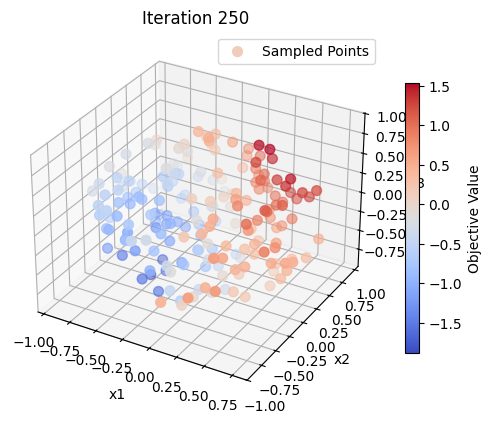

Optimal X: [-0.48475352 -0.12183532 -0.85362875], Optimal Value: -1.8733443662817018


In [165]:
# run
best_x, best_y = constrained_bayesian_optimization(n_iters=250)
print(f"Optimal X: {best_x}, Optimal Value: {best_y}")